## Advanced Lane Finding Project

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from skimage import io
import sklearn as sk
from util import Camera, Perspective, LaneFinder, Line
import re

%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


## Camera calibration using chessboard images


To get camera distortion matrix we have to calibrate camera using chessboard images and OpenCV's functions findChessboardCorners() and calibrateCamera(). Two resulting variables: mtx, dist can be used later to apply to any new image using OpenCV's functions getOptimalNewCameraMatrix() and undistort().

In [2]:
camera = Camera('camera_cal')

## Image undistortion example

Here's an example of a chessboard that is used to calibrate camera object:

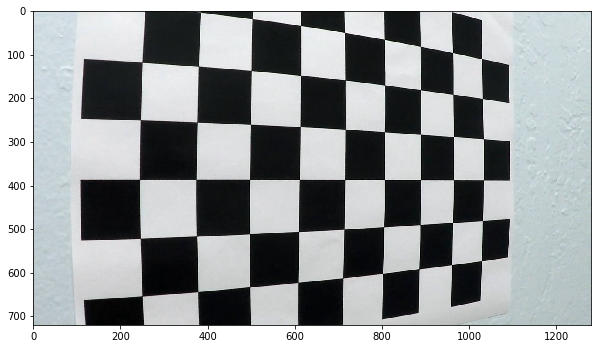

In [3]:
chessboard = cv2.imread('camera_cal/calibration5.jpg')
plt.imshow(chessboard)

Example resulting undistorted chessboard image:

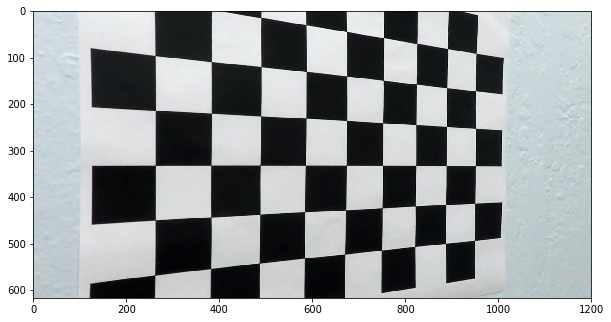

In [4]:
chessboard_undist = camera.undistort(chessboard)
plt.imshow(chessboard_undist)

It can be easily noticed that line destortions introduced by lenses were removed.

## Perspective transformations

According to Oxford dictionary, perspective is "the appearance of viewed objects with regard to their relative position, distance from the viewer, etc.". In perspective projection "the distance and angles are not preserved and parallel lines do not remain parallel. Instead, they all converge at a single point called center of projection or projection reference point."

Our task will be to extract the road image from camera applying reverse perspective projection. We can do that by first defining the region of interest that denotes the road on a plain. On the plain of the road it would look like a rectangle but after perspective projection the rectange becomes a trapeze. As had been said, we should apply the reverse transformation, so we must define the trapeze polygon first.

In [5]:
h = chessboard_undist.shape[0]
w = chessboard_undist.shape[1]

def read_image_dir(dir):
    return {re.search('([^\\\]+)\..*$', f).group(1): camera.undistort(io.imread(f)) for f in glob.glob('{}/*.*'.format(dir))}
    
test_images = read_image_dir('test_images')

## Warp perspective: source

Here's how I defined the polygon of interest:

In [6]:
perspective = Perspective(h, w)

perspective.polygon

array([[  495.,   417.],
       [  742.,   417.],
       [   80.,   617.],
       [ 1200.,   617.]], dtype=float32)

The polygon of interest cannot be too wide to exclude objects possibly appearing on the roadside. It also cannot be too narrow and include the marking lines even if camera is slightly uncentered.

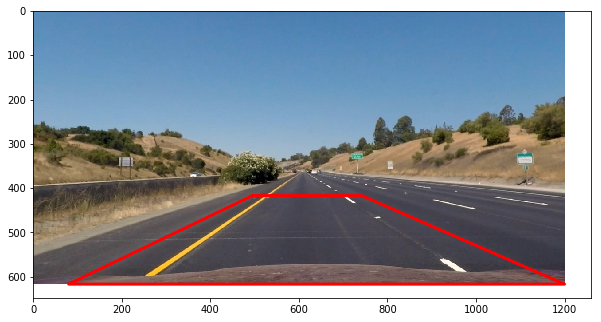

In [7]:
pf = perspective.polygon_frame()

plt.imshow(test_images['straight_lines1'])
plt.plot(pf[:, 0], pf[:, 1], 'r', lw=3)

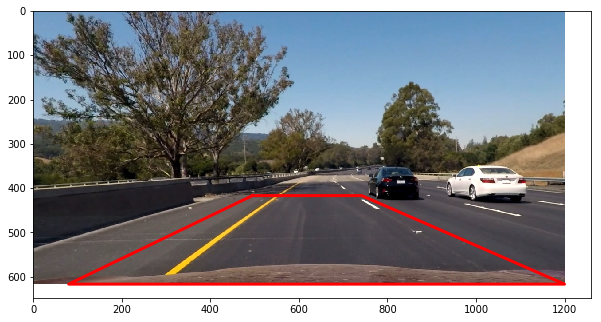

In [8]:
plt.imshow(test_images['test6'])
plt.plot(pf[:, 0], pf[:, 1], 'r', lw=3)

We must check now if our selected polygon is correct. We apply perspective warp to the image. The lines must remain parallel.

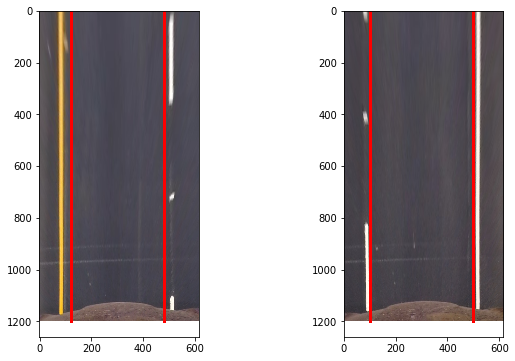

In [9]:
perspective = Perspective(h, w)

test_images_warped = {t: perspective.warp(img) for t, img in test_images.items()}

straight1 = perspective.warp(test_images['straight_lines1'])
straight2 = perspective.warp(test_images['straight_lines2'])
    
fig = plt.figure()

plt.subplot(121)
plt.imshow(test_images_warped['straight_lines1'])

plt.plot((120, 120), (0, test_images_warped['straight_lines1'].shape[0]), 'r', lw=3)
plt.plot((480, 480), (0, test_images_warped['straight_lines1'].shape[0]), 'r', lw=3)

plt.subplot(122)
plt.imshow(straight2)

plt.plot((100, 100), (0, test_images_warped['straight_lines2'].shape[0]), 'r', lw=3)
plt.plot((500, 500), (0, test_images_warped['straight_lines2'].shape[0]), 'r', lw=3)

## Feature extraction

To make vehicle follow the road, we need to extract line pixels and get rid of possible noise and irrelevant features. In this step we will apply Sobel operator to detect gradients (edges), do some mask extraction and color tranformations.

First let's get rid of the static hood image by applying mask to the image.

In [10]:
# hood_mask = cv2.cvtColor(cv2.imread('hood_mask.png'), cv2.COLOR_BGR2GRAY)
# hood_mask_undist = camera.undistort(hood_mask)
# hood_mask_warped = perspective.warp(hood_mask_undist)

def apply_test_image_and_plot(images, f):
    take = 5
    images = dict(list(images.items())[0:take])
    
    fig, axarr = plt.subplots(1, len(images), figsize=(16, 12))

    for i, t in enumerate(images):
        img = images[t]
        img = f(img)
        axarr[i].axis('off')
        axarr[i].imshow(img)
        axarr[i].set_title(t)
        
    fig.tight_layout()
    fig.subplots_adjust(top=1.2)

The image processing pipeline looks like follows:
 * Gausian blur with kernel size 5
 * Horizontal Sobel with threshold (10, 255) and kernel size 7
 * Vertical Sobel with threshold (60, 255) and kernel size 7
 * Magnitude Sobel (sqrt(x^2 + y^2)) with threshold (40, 255) and kernel size 7
 * Direction Sobel (arctan2(abs(x), abs(y))) with threshold (pi/2, pi/4) and kernel size 7
 * Apply a yellow/white color mask

Below we demonstrate each step separately on 5 warped test images.

### Gausian blur

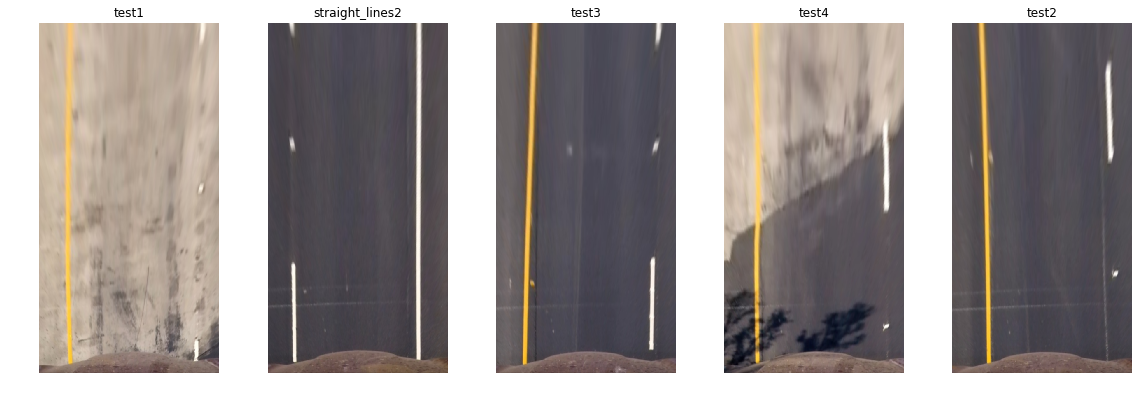

In [11]:
from util import FeatureExtractor
extractor = FeatureExtractor()

apply_test_image_and_plot(test_images_warped, extractor.gaussian_blur)

### Sobel X

Since lane lines are vertical, the X sobel operator detects X gradients of color value change.

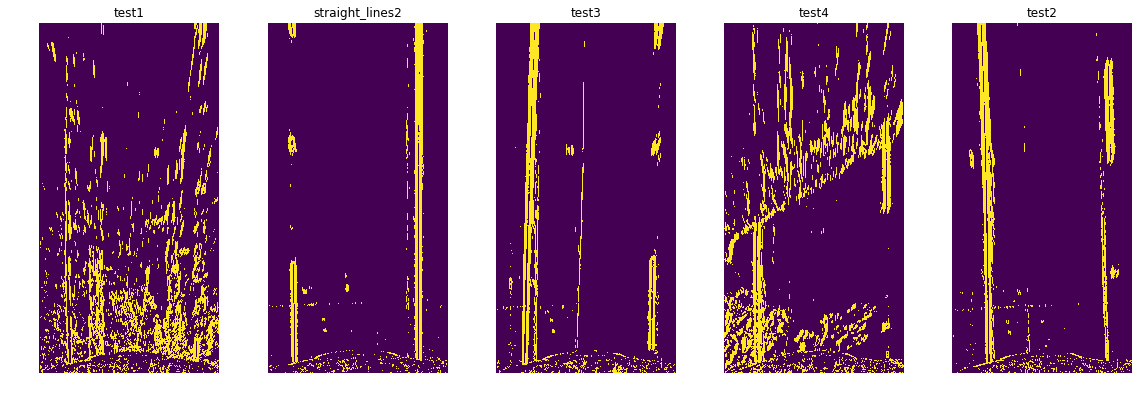

In [12]:
apply_test_image_and_plot(test_images_warped, lambda x: extractor.abs_sobel_thresh(extractor.gaussian_blur(x), 1, 0, (10, 255)))

### Sobel Y

As can be seen, some images of the road have horizontal lines (scratches?), these pixels must not be detected as lines, we will extract them later.

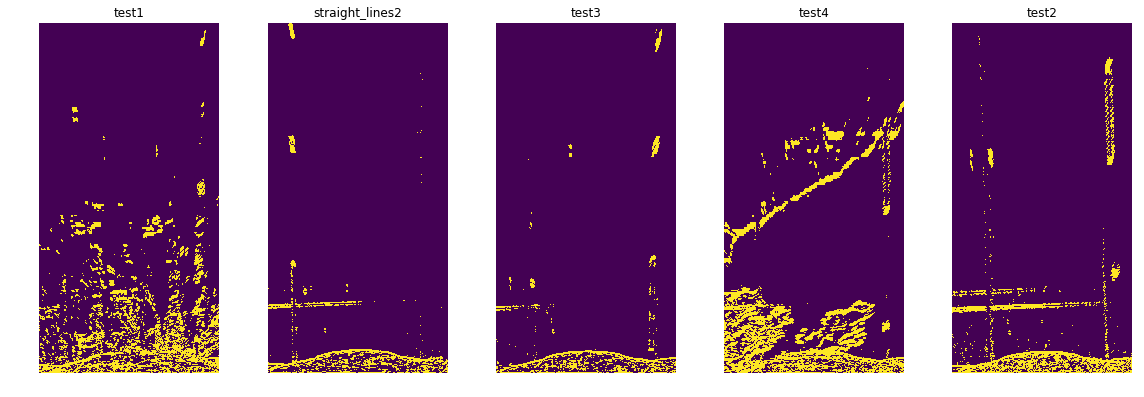

In [13]:
apply_test_image_and_plot(test_images_warped, lambda x: extractor.abs_sobel_thresh(extractor.gaussian_blur(x), 0, 1, (10, 255)))

### Sobel XY thresholded by magnitude

Seems that this feature extractor detects vertical lines pretty well.

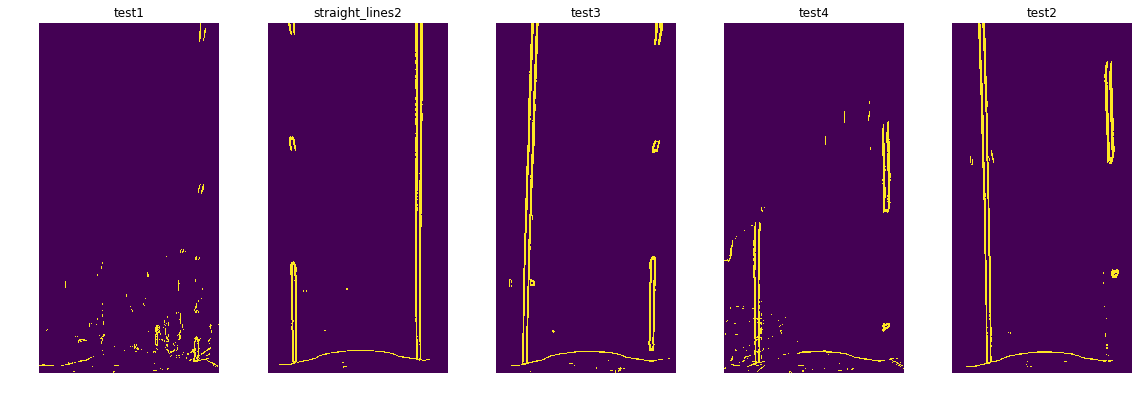

In [14]:
apply_test_image_and_plot(test_images_warped, lambda x: extractor.mag_thresh(extractor.gaussian_blur(x), (40, 255)))

### Sobel XY thresholded by angle

Seems that this feature detector is good in detecting "noise", we will use it's output to extract from the combined result.

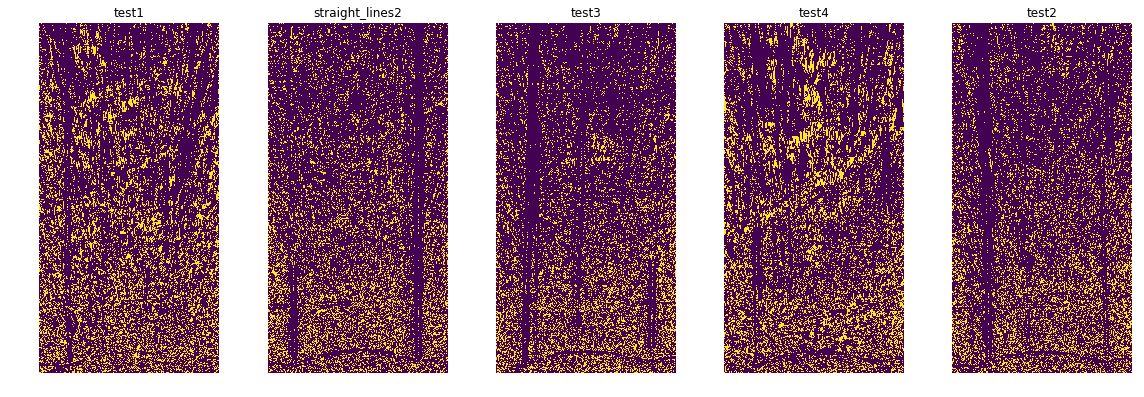

In [15]:
apply_test_image_and_plot(test_images_warped, lambda x: extractor.dir_threshold(extractor.gaussian_blur(x), (0.5, 1.0)))

### Combination of binary thresholded feature detectors

Now we can combine all previous transformations together.

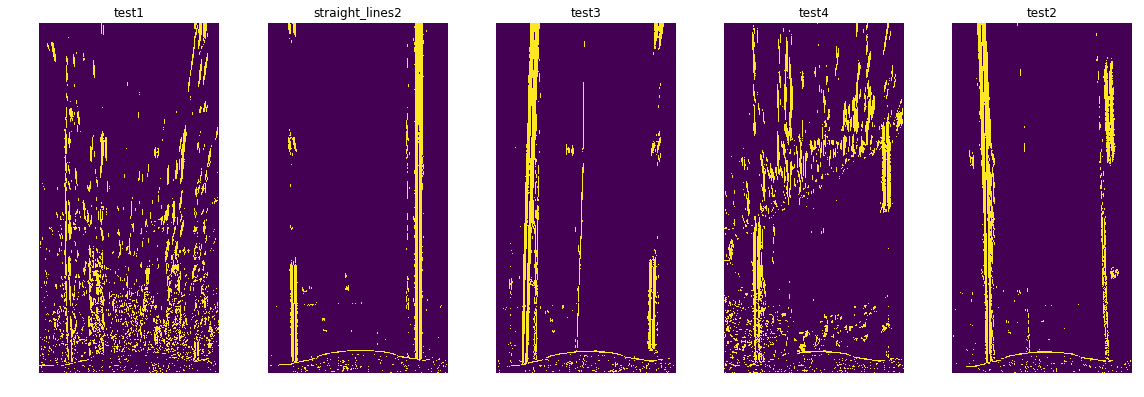

In [16]:
def combined_threshold(img):
    img = extractor.gaussian_blur(img)

    gradx = extractor.abs_sobel_thresh(img, 1, 0, (10, 255))
    grady = extractor.abs_sobel_thresh(img, 0, 1, (10, 255))

    mag_binary = extractor.mag_thresh(img, (40, 255))
    dir_binary = extractor.dir_threshold(img, (0.5, 1.1))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 0)) | ((mag_binary == 1)) & (dir_binary == 0)] = 1
    
    return combined
    
apply_test_image_and_plot(test_images_warped, lambda x: combined_threshold(x))


### Line color detection

Since we're interested in road lines, they can be painted with white or yellow. We convert our road image from RGB to HLS and HSV and apply cv.inRange with specified color range. Here's the demonstration of an RGB palette with all possible color values.

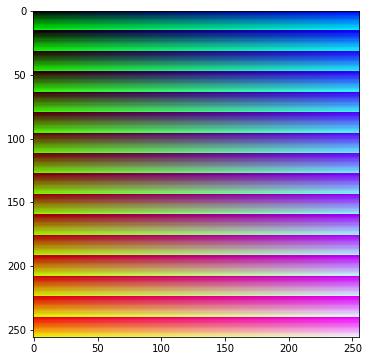

In [17]:
rgb = np.zeros((256, 256, 3), dtype=np.uint8)
for r in range(0, 16):
    for g in range(0, 16):
        for b in range(0, 256):        
            rgb[r * 16 + g, b] = (r * 16, g * 16, b)
            
plt.imshow(rgb)

Now we show the values that we assume yellow color by extracting all other values from the palette.

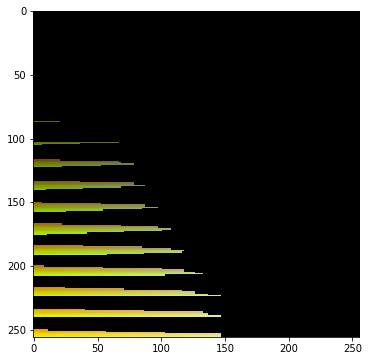

In [18]:
plt.imshow(cv2.bitwise_and(rgb, rgb, mask=extractor.yellow_threshold(rgb)))

We do the same for white.

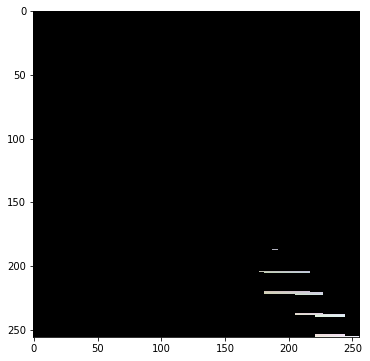

In [19]:
plt.imshow(cv2.bitwise_and(rgb, rgb, mask=extractor.white_threshold(rgb)))

Now this white and yellow color filters can be applied to the images of the road.

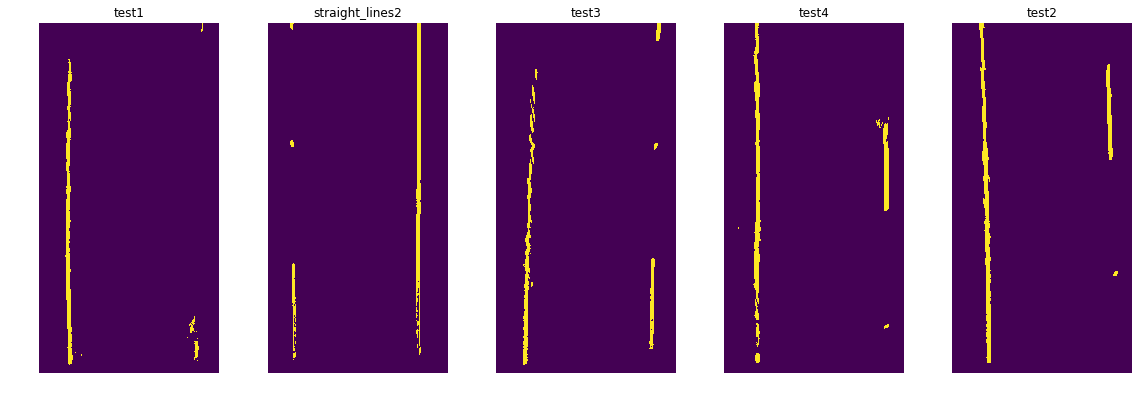

In [20]:
def combined_color_threshold(img):
    img = extractor.gaussian_blur(img)
    return extractor.white_threshold(img) | extractor.yellow_threshold(img)
    
apply_test_image_and_plot(test_images_warped, lambda x: combined_color_threshold(x))

### Threshold detectors with applied color filters

Finally we must make sure that pixels detected by gradient extractors are close to white or yellow color. The result is shown below.

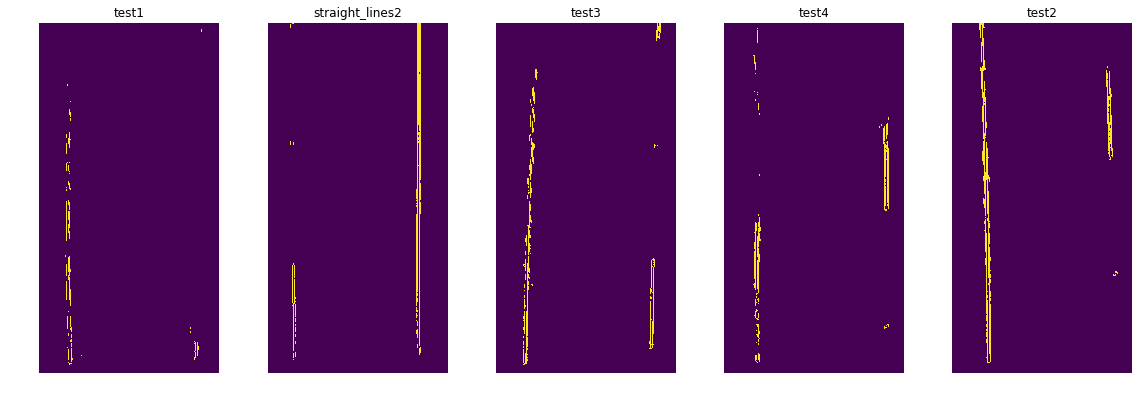

In [21]:
def combined_threshold_with_color(img):
    img = extractor.gaussian_blur(img)
    
    gradx = extractor.abs_sobel_thresh(img, 1, 0, (10, 255))
    grady = extractor.abs_sobel_thresh(img, 0, 1, (10, 255))

    mag_binary = extractor.mag_thresh(img, (40, 255))
    dir_binary = extractor.dir_threshold(img, (0.5, 1.1))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 0)) | ((mag_binary == 1)) & (dir_binary == 0)] = 1

    color_binary = extractor.color_threshold(img)

    total_binary = np.zeros_like(combined)
    total_binary[(color_binary > 0) & (combined > 0)] = 1

    return total_binary

apply_test_image_and_plot(test_images_warped, lambda x: combined_threshold_with_color(x))

It can be notices that our feature extractor detects gradient changes of the white and yellow road lines. Now when pipeline is ready we can try to apply it to the problematic situations found on the video (shadows, bumpy road etc). Seems that filter works OK.

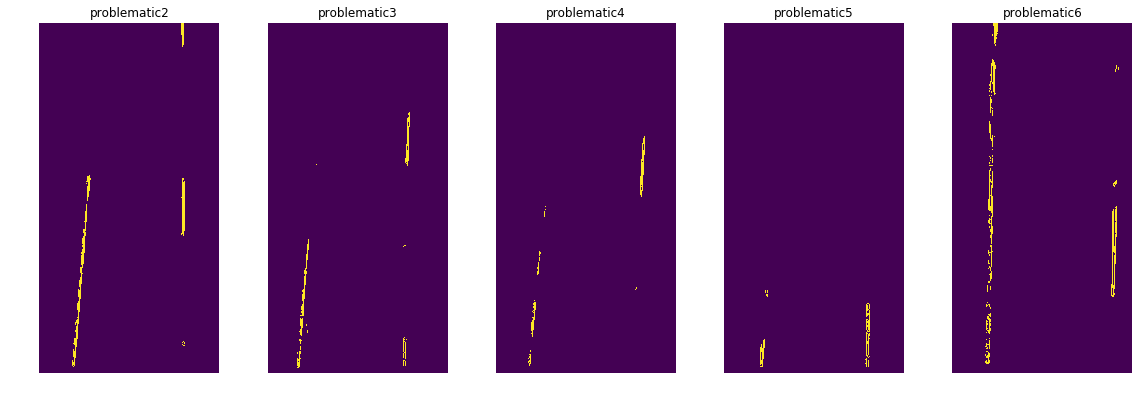

In [22]:
problematic_images = read_image_dir('problematic_images')
problematic_images_warped = {t: perspective.warp(img) for t, img in problematic_images.items()}

apply_test_image_and_plot(problematic_images_warped, lambda x: combined_threshold_with_color(x))

## Fit polynomial

Our next task is to find the pixels of the left and right lines and fit the polinomial in order to detect the curvature. We must find aproximate start positions of the lines. To do that we calculate histograms. Here is an example of histogram (bottom half of the image, with rolling window 16 pixels applied) calculated from a test image.

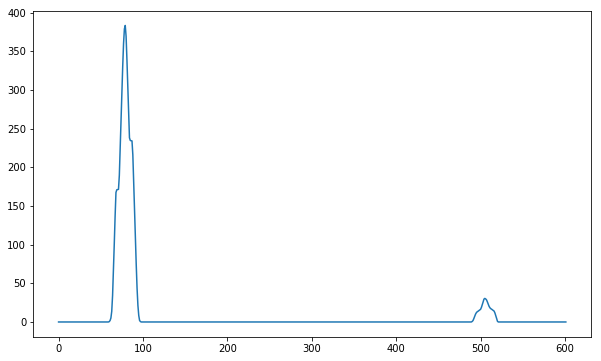

In [23]:
lane_finder = LaneFinder(combined_threshold_with_color(test_images_warped['straight_lines1']))

plt.plot(lane_finder.histogram)

## Fit with polynomial

After starting X positions found, we can fit the 2nd order polynomial, with starting Y position at the bottom of the image.

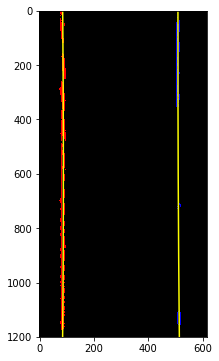

In [24]:
def fit_polinomial(fit, x):
    return fit[0] * x ** 2 + fit[1] * x + fit[2]

def plot_fit(pp, lane_finder):
    out_img = np.uint8(np.dstack((lane_finder.image, lane_finder.image, lane_finder.image))*255)
    ploty = np.linspace(0, lane_finder.image.shape[0] - 1, lane_finder.image.shape[0])
    
    left_fitx = fit_polinomial(lane_finder.left_fit, ploty)
    right_fitx = fit_polinomial(lane_finder.right_fit, ploty)

    leftx, lefty, rightx, righty = lane_finder.extract_pixels()
    
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    pp.imshow(out_img)
    pp.plot(left_fitx, ploty, color='yellow')
    pp.plot(right_fitx, ploty, color='yellow')

plot_fit(plt, lane_finder)

## Calculate curvead

Curvead of the lanes can be calculated using coefficients of the polynomial and formulas given in the lectures. The following coefficients also applied in order to convert pixels to meters of the radius (see function calc_curverad() under "Calculate curvead" paragraph):

```
ym_per_pix = 30 / 720 # meters per pixel in y dimension
xm_per_pix = 3.7 / 700 # meters per pixel in x dimension
```

In [25]:
print(lane_finder.left_curvead, 'm', lane_finder.right_curvead, 'm')

68334.5652659 m 111292.822444 m


## Draw detected lanes

Now we can apply all methods described above to visualize detected lanes on the project video. We do that by drawing polynomials, applying reverse warp transformation and add on top of the video frame as a semi-transparent layer. Here how it looks like:

In [26]:
class FrameState():
    camera = None
    perspective = None
    extractor = None
    
    left_line = None
    right_line = None

    def __init__(self, camera, perspective, extractor):
        self.left_line = Line()
        self.right_line = Line()
        
        self.camera = camera
        self.perspective = perspective
        self.extractor = extractor

    def sanity_check(self, line, fit, yvals, curvature):
        if line.fit is None:
            line.radius_of_curvature = curvature
            line.fit = fit
            line.detected = True
            line.count_skip = 0
        elif not fit is None:
            a = np.column_stack((line.fit[0] * yvals ** 2 + line.fit[1] * yvals + line.fit[2], yvals))
            b = np.column_stack((fit[0] * yvals ** 2 + fit[1] * yvals + fit[2], yvals))
            ret = cv2.matchShapes(a, b, 1, 0.0)

            if (ret < 0.005) | (line.count_skip > 10):
                line.radius_of_curvature = curvature
                line.fit = fit
                line.detected = True
                line.count_skip = 0
            else:
                line.detected = False
                line.count_skip += 1
        else:
            line.detected = False
            line.count_skip += 1            

        return line.fit[0] * yvals ** 2 + line.fit[1] * yvals + line.fit[2]    
   
    def anotate_frame(self, frame):
        undist = self.camera.undistort(frame)
        warped = self.perspective.warp(undist)
        binary = self.extractor.pipeline(warped)

        lane_finder = LaneFinder(binary)
        
        out_img = np.uint8(np.dstack((binary, binary, binary)) * 255)
        ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0])

        left_fitx = self.sanity_check(self.left_line, lane_finder.left_fit, ploty, lane_finder.left_curvead)
        right_fitx = self.sanity_check(self.right_line, lane_finder.right_fit, ploty, lane_finder.right_curvead)

        warp_zero = np.zeros_like(binary).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))   

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

        newwarp = self.perspective.unwarp(color_warp, (undist.shape[1], undist.shape[0]))

        # Combine the result with the original image
        layered = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
        
        curverad = 0
        if not self.left_line.radius_of_curvature is None and not self.right_line.radius_of_curvature is None:
            curverad = (self.left_line.radius_of_curvature + self.right_line.radius_of_curvature) / 2
        elif not self.left_line.radius_of_curvature is None:
            curvead = self.left_line.radius_of_curvature
        elif not self.right_line.radius_of_curvature is None:
            curvead = self.right_line.radius_of_curvature

        offset = lane_finder.offset if not lane_finder.offset is None else 0
            
        cv2.putText(layered, "Curvature: %s m" % str(round(curverad)) + " Offset: %s" % str(round(offset)),
            (20, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 4, cv2.LINE_AA) 
        
        return layered
    
    def __call__(self, frame):
        return self.anotate_frame(frame)
    

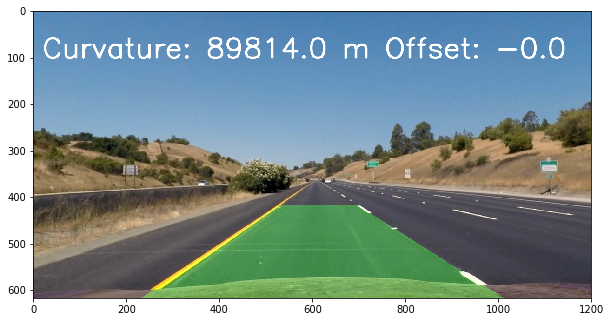

In [27]:
state = FrameState(camera, perspective, extractor)

plt.imshow(state(io.imread('test_images/straight_lines1.jpg')))

## Video demonstration

Here, the visualization of the lanes detection performed using project_video.mp4:

https://youtu.be/7Qu0B_IvBd4

In [28]:
from IPython.display import clear_output

In [52]:
state = FrameState(camera, perspective, extractor)

vid = cv2.VideoCapture("project_video.mp4")

try:
    while(True):
        ret, frame = vid.read()
        if not ret:
            vid.release()
            break
            
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        axis('off')

        plt.imshow(state(frame))       
        
        show()

        clear_output(wait=True)
        
except KeyboardInterrupt:
    vid.release()

In [29]:
from moviepy.editor import VideoFileClip

test_output = 'project_video_result.mp4'
clip = VideoFileClip('project_video.mp4')
fl_clip = clip.fl_image(FrameState(camera, perspective, extractor))
%time fl_clip.write_videofile(test_output, audio=False)

C:\Users\up\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\filter\__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '
C:\Users\up\Anaconda3\envs\carnd-term1\lib\site-packages\moviepy\audio\io\readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))



MoviePy: building video file project_video_result.mp4
----------------------------------------

Writing video into project_video_result.mp4
Done writing video in project_video_result.mp4 !                         
Your video is ready !
Wall time: 3min 34s


## Problematic cases

Some problematic cases were discovered during testing the pipeline on the challenge video. After some adjusting they are performing pretty well.

In [30]:
problematic_files = glob.glob('problematic_images/problematic*.png')
problematics = []
for f in problematic_files:
    problematic_image = io.imread(f)
    problematic_undist = camera.undistort(problematic_image)
    problematic_warped = perspective.warp(problematic_undist)
    problematic_binary = extractor.pipeline(problematic_warped)
    problematic_lane_finder = LaneFinder(problematic_binary)

    problematics.append(dict(
        image=problematic_image,
        undist=problematic_undist,
        warped=problematic_warped,
        binary=problematic_binary,
        lane_finder=problematic_lane_finder
    ))
    
def plot_diagnostics(i):
    fig, ((a,b),(c,d)) = plt.subplots(2, 2, figsize=(18, 12))
    a.imshow(problematics[i]['image'])
    b.imshow(problematics[i]['warped'])
    c.imshow(problematics[i]['binary'])
    plot_fit(d, problematics[i]['lane_finder'])
    

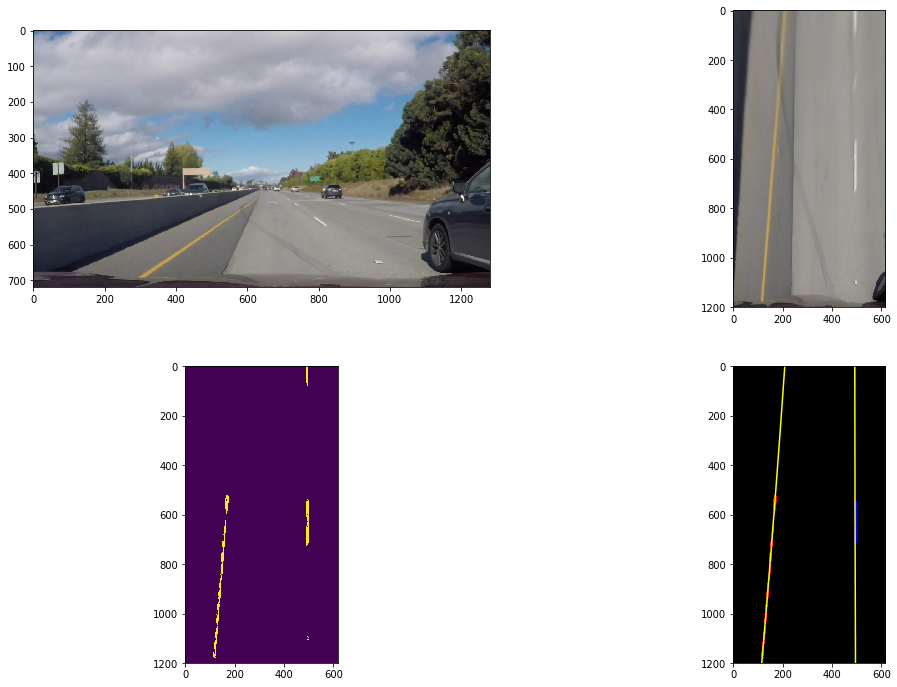

In [31]:
plot_diagnostics(0)

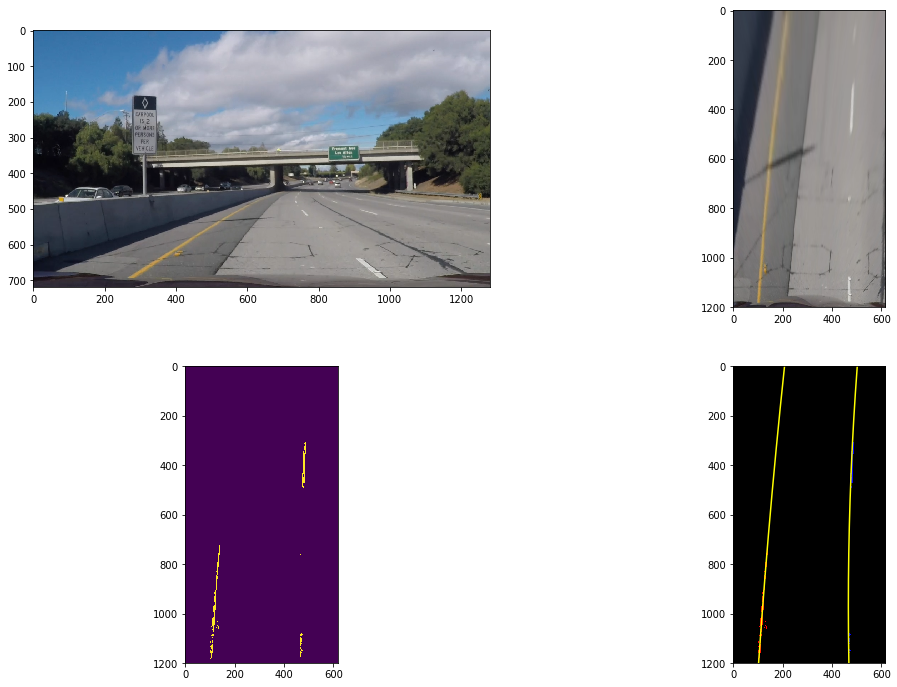

In [32]:
plot_diagnostics(1)

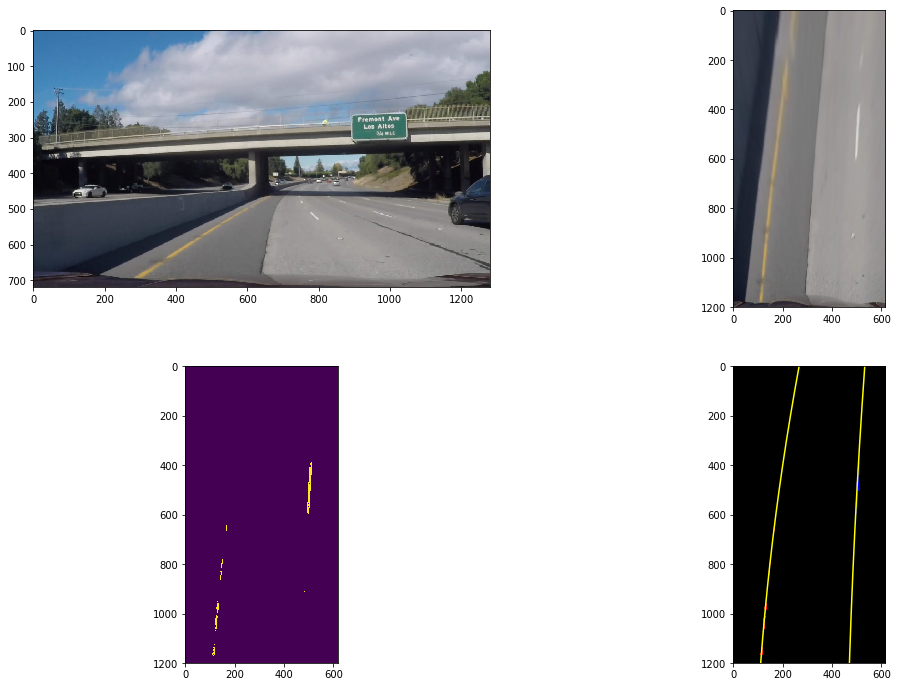

In [33]:
plot_diagnostics(2)

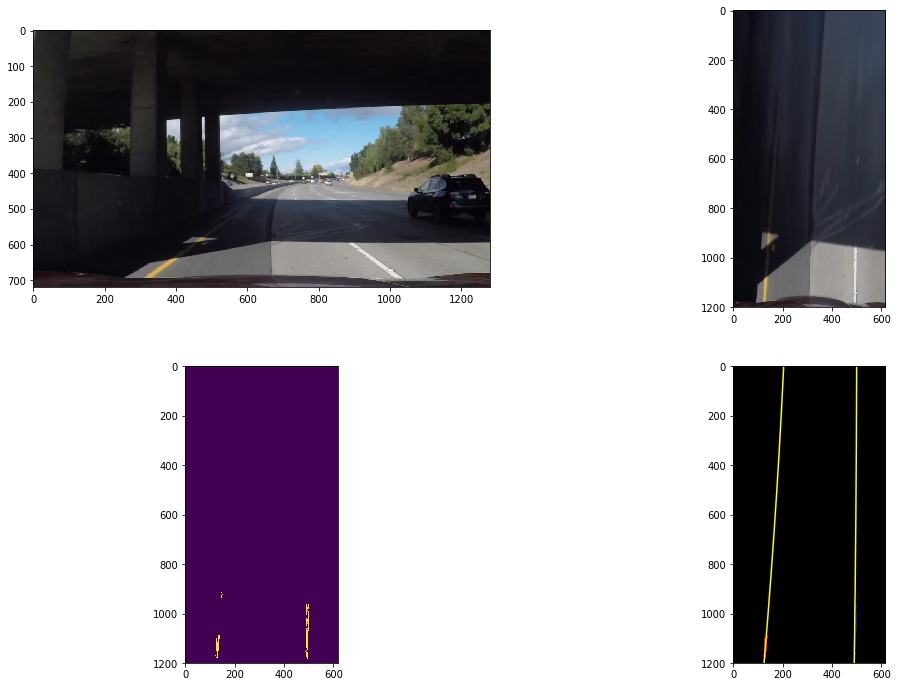

In [34]:
plot_diagnostics(3)

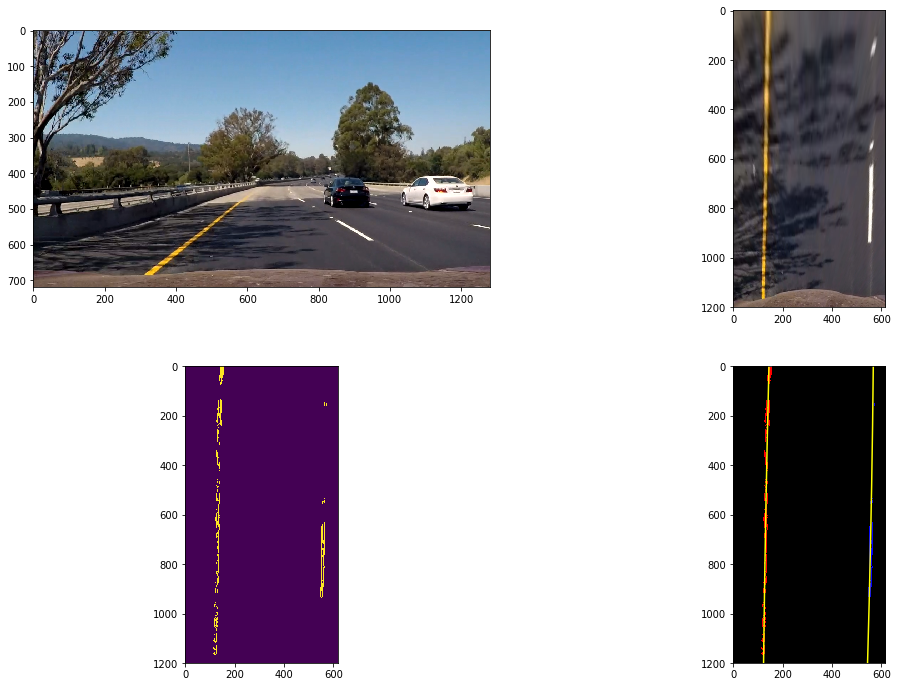

In [35]:
plot_diagnostics(4)

## Discussion

My project still fails on the challenge videos in complicated cases because of the different road surfaces and shadowed regions.

What can be done to improve the performance of pipeline:
 * Error handling: possibly check the mean squared error of polyfits and decide how robust the valuation.
 * Simple 2nd polynomial fit can be replaced by a more error prone method such as RASNAC.
 * Smoothing between frames. Line curvature cannot dramaticaly change. A smoothing and averaging would help a lot.
 * Challenge video proved the inability of the algorithm to deal in shadowed and overlightened regions. Such cases can be detected (small relative amount of pixels or lots of pixels distributed across the frame) and the pipeline must act very carefully.
 
What was most dificult in this project is to find the accurate parameters and combinations of binary feature extractors.